____
____
# CSCP 3022 Project
## Modelling Wine Quality

Rouzbeh Salehi Pour  
2019-12-14  
____
____

  


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set()

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model

---

## Introduction  

### Problem 
* The quality of wine is assumed to be subjective and dependant on the personal taste of an individual.
* However, there may be some physicochemical properties of wines which would influence the quality score given by an individual.

### Goals  
* Identify if there is a relationship between the physicochemical properties and the quality of white wines.
* Determine if the quality of white wines can be modeled based on their physicochemical properties.

### Regression or classification
* Due to the method that quality is scored and the quantity of data available, both regression and classification models will be used.
    * Quality scores will be combined to form a classificed variables (i.e. quality < 5 = below average, quality == 5 = average, quality > 5 = above average).

### Inference or prediction
* This project will attempt to predict the quality of a wine based on its physicochemical properties.

### Types of analyses
* Since both regression and classification models will be used, the following type of analyses will be attempted:
    * Linear regression
    * Logistic regression
    * K-nearest neighbors
    * Support-vector machine

---

## Data

### Description
* The data is comprised of a csv file of 4898 instances for white wine.
* The csv file contains 11 input variables and 1 output variable.
    * The input variables are the physicochemical properties of the wine.
        * Units for all variables are not provided.
    * The output variable is the wine quality.
        * Obtained as the median of at least 3 evaluations made by wine experts.
        * Quality ranges from 0 (bad) to 10 (excellent).
* The data is listed as follows:
    * Input variables (based on physicochemical tests):   
        1 - fixed acidity  
        2 - volatile acidity  
        3 - citric acid  
        4 - residual sugar  
        5 - chlorides  
        6 - free sulfur dioxide  
        7 - total sulfur dioxide  
        8 - density  
        9 - pH  
        10 - sulphates  
        11 - alcohol  
    * Output variable (based on sensory data):  
        12 - quality (score between 0 and 10)  

### Source
* Data obtained from the UCI ML data repository: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [2]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

# source for code below: https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
wine.columns = wine.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

---

## Exploratory Data Analysis (EDA)

### Data distribution
* To understand how the dataset is distributed for each variable, a boxplot per variable is constructed below.

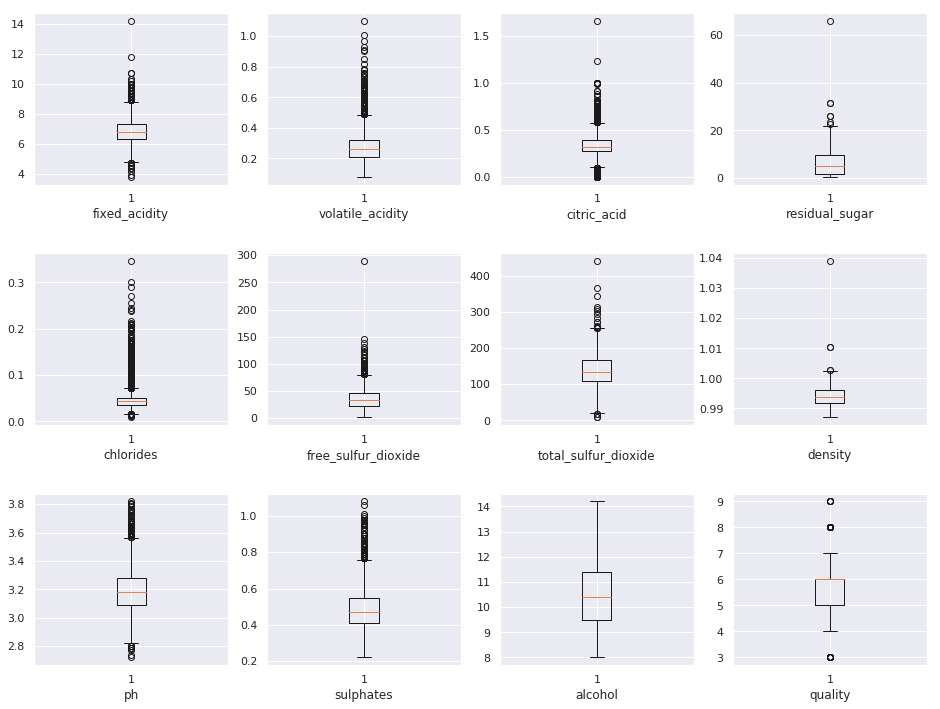

In [3]:
fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)     # spacing between subplots

c = 0;
# create boxplot of all variables
for k in range(3):     # going through row of subplot
    for i in range(4):     # going through column of subplot
        ax[k][i].boxplot(wine[wine.columns[c]])
        ax[k][i].set_xlabel(wine.columns[c])
        c += 1

* Many of the factors are right skewed.
    * These include all factors except pH and quality.
* Much of the right skewness of these factors are caused by outliers of large values.
    * This may indicate that they have a log distribution.
* Ignoring the outliers, the boxplots show that many of the factors have a symmetric distribution.
    * These include all factors except residual sugar and quality.

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64

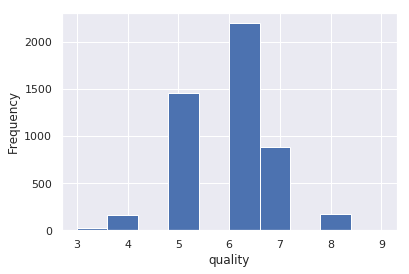

In [4]:
wine.quality.plot.hist().set_xlabel('quality');
wine.quality.value_counts().sort_index()

* Much of the quality data is concentrated at scores 5 and 6. 
    * There are not many representative instances for very good or bad quality wine.
        * There are no wines of quality 0-2 or 10. 
* For this reason, a classification model may be better suited for this problem.
    * I.e. quality < 5 = below average, quality == 5 = average, quality > 5 = above average.
* When applying a linear regression model, under sampling of instances where the quality is 5 or 6 may be required to avoid over-representation of these values.

### Data correlation

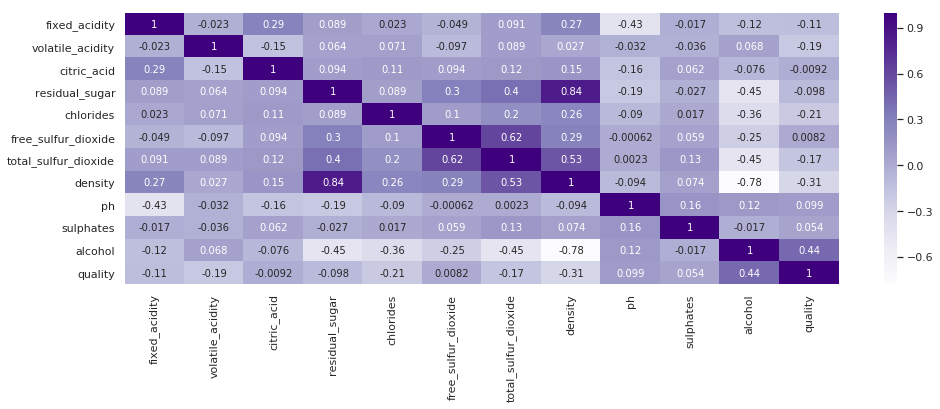

In [5]:
fig, ax = plt.subplots(figsize=(16,5))
correlation = wine.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True, ax=ax, cmap="Purples");

* Alcohol is negatively correlated with many of the other factors, including density, residual sugar, total sulphur dioxide, and chlorides.
    * This may be due to the properties of alcohol.
        * For example: since the average wine has a water content of 85%, and alcohol has a lower density than water, it makes sense that there is a negative correlation between alcohol and density.
* There is a negative correlation between pH and fixed acidity.
* There is a noticeable positive correlation between density and residual sugar, total sulfur dioxide and free sulfur dioxide, density and total sulphur dioxide, and alcohol and quality.
* Assuming a strong correlation is defined as a correlation greater than 0.7 or less than -0.7, there are only two strong correlation present between the factors (density and residual sugar, density and alcohol).

### Data transformation

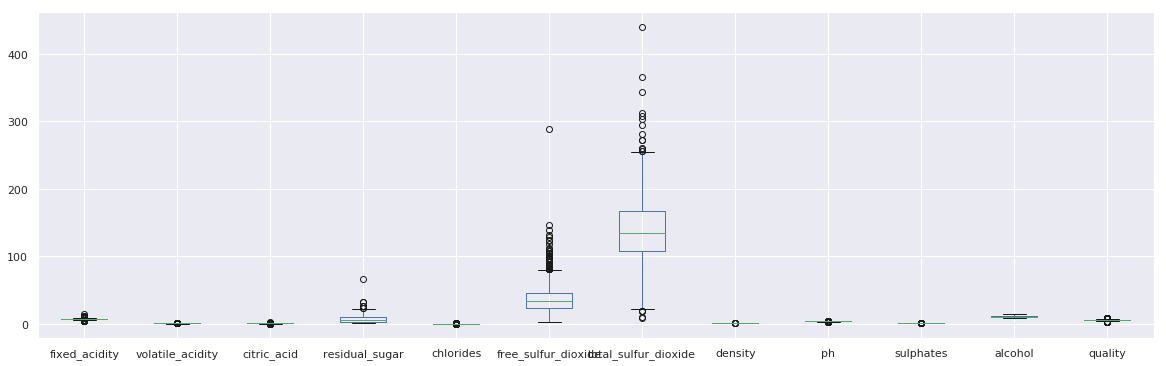

In [6]:
wine.plot.box(figsize=(20,6));

* The differences in the range of data is evident in the boxplots above.
* Since KNN is intended to be used as a model on the dataset, all the input data will need to be scaled or normalized.
* For the classification models intended to be used, the quality factor will need to be transformed to form appropriate thresholds/classifications.

### Conclusion
* Many of the factors seems to have outliers, some of which may be due to having a log distribution.
* The dataset has no missing data values.
* Based off the correlation table, it seems that alcohol and density will be the most important factors in my analysis since they have the largest correlation with quality. 
* Alcohol is also has a weak negative correlation with five other factors, enforcing my assumption that alcohol will be one of the important factors.
    * The five other factors may not be significant in the regression model due to the correlation.
* A difficulty that may come up is that for a dataset of 11 input variables, there are only a few moderate correlations between the input and the output variables, therefore there is the potential that the models may not generate high scores.
* This also may change once the quality factor is transformed to implement classification models. 
    * There is a risk of creating a class label imbalance when making this transformation.
* My initial hypothesis is that that alcohol and density may be the best factors to estimate white wine quality (based on the correlation matrix).

---

## Data cleaning

* To clean the data, the initial plan was to remove any data point that were not between the minimum and maximum whiskers of each variable's respective boxplot.
    * This equates to removing data which is not between (Q1 - 1.5 x IQR) and (Q3 + 1.5 x IQR), or outside +/- 2.698 standard deviations (99.3%), of each input variable.
* However, to apply this method of cleaning, the data would need to somewhat follow a normal distribution (before cleaning) to avoid cutting off valuable data points.
* After discussing this with the course instructor, an appropriate method for cleaning would be a visual inspection and cleaning of each variable.
    * This method would be beneficial since the dataset for each variable would be individually assessed instead of collectively cleaned by one rule.
    * Since there are only 11 input variables to visually inspect, this method is also not too difficult to implement.

### Inspection

* To understand how each outlying the data point is spread, strip plots for each variable have been constructed below.

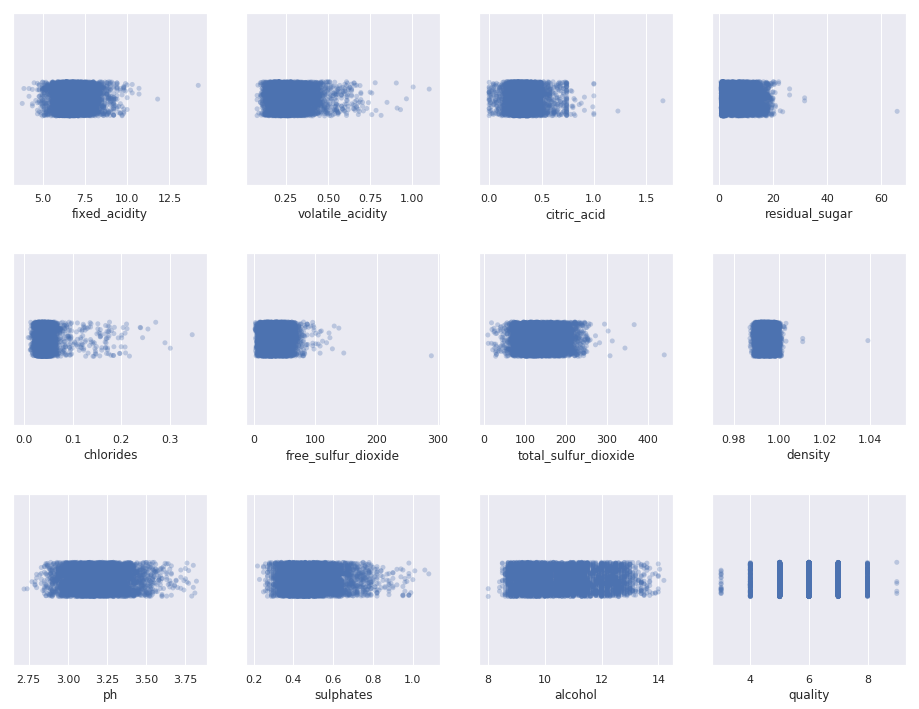

In [7]:
fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)     # spacing between subplots

c = 0;
# create striplots of all variables
for k in range(3):     # going through row of subplot
    for i in range(4):     # going through column of subplot
        sns.stripplot(wine[wine.columns[c]], data=wine, jitter=True, alpha=0.3, ax=ax[k][i]);
        ax[k][i].set_xlabel(wine.columns[c])
        c += 1

* Notes to take from the strip plots and identified outliers:
    * Much of the variables have outliers that lie on the higher range of values.
    * Fixed acidity: 2 outliers greater than **11.25**.
    * Volatile acidity: points greater than **0.75** begin to spread further away from each other.
    * Citric acid: there seems to be a concentration of points around certain values, such as 0, ~0.75, and 1. However, the data points beyond ~0.75 seem to be sparse compared to the rest of the data, therefore the ~20 points greater than **0.75** will be considered as outliers.
        * Keeping the points near value of 1 may cause an imbalance in the modelling.
    * Residual sugar: 5 outliers greater than **25**.
    * Chlorides: noticeable spreading of 8 points greater than **0.225**.
    * Free sulfur dioxide: <10 points greater than **~110** seem to begin spreading away from the cluster, with one noticeable outlier. 
    * Total sulfur dioxide: points greater than **~290** begin to show noticeable spreading.
    * Density: 3 outliers greater than **1.005**.
    * pH: no significant outliers.
    * Sulphates: arguably 2 outliers greater than **1.05**. 
    * Alcohol: no significant outliers.
* For each data value which is considered as an outlier, its row will be removed from the dataset.


### Cleaning

In [8]:
wine.isna().sum()     # check for any NA values

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

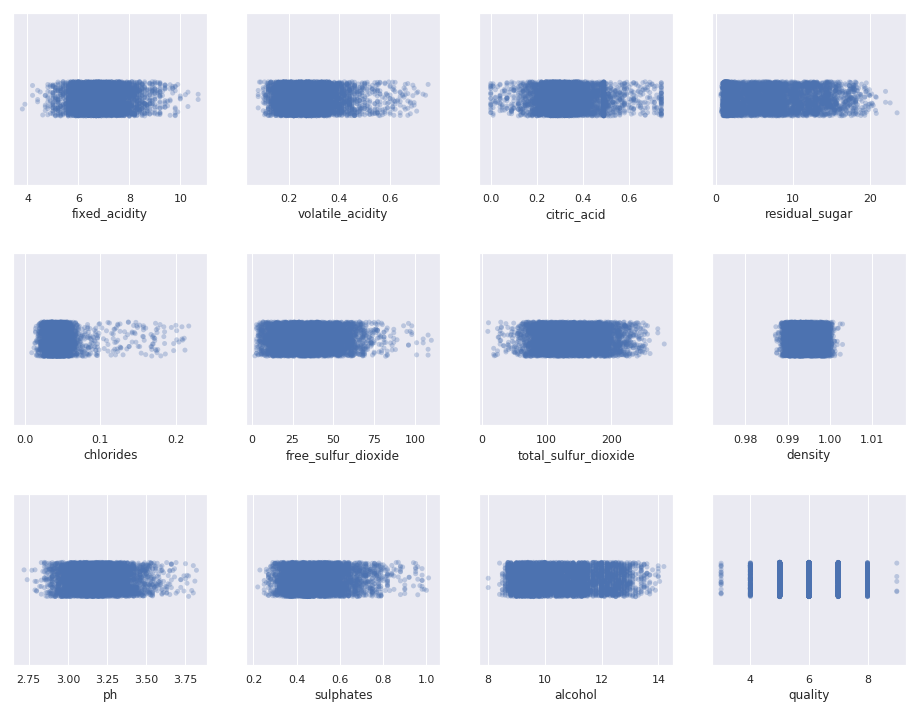

In [9]:
fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)     # spacing between subplots

outlier_ranges = [11.25, 0.75, 0.75, 25, 0.225, 110, 290, 1.005, 999, 1.05, 999, 999]     # cutoff points for outliers

cleaned_count = []     # number of data points cleaned
total_len = len(wine.index)

c = 0;
# create striplots of all variables
for k in range(3):     # going through row of subplot
    for i in range(4):     # going through column of subplot
        wine_cleaned = wine.copy()
        wine_cleaned = wine_cleaned[wine_cleaned[wine.columns[c]] <= outlier_ranges[c]]     # remove outliers
        sns.stripplot(wine_cleaned[wine.columns[c]], data=wine_cleaned, jitter=True, alpha=0.3, ax=ax[k][i]);     # make new stripplot of cleaned data
        ax[k][i].set_xlabel(wine.columns[c]);
        cleaned_count.append(total_len-len(wine_cleaned.index))
        c += 1

In [10]:
cleaning_per_factor = dict(zip(wine.columns, cleaned_count))     # combine lists to dictionary

for key, value in cleaning_per_factor.items():
    print("{:<22} {}".format(key, value))

print("{:<22} {}".format("Total", sum(cleaned_count)))

fixed_acidity          2
volatile_acidity       12
citric_acid            22
residual_sugar         5
chlorides              8
free_sulfur_dioxide    9
total_sulfur_dioxide   7
density                3
ph                     0
sulphates              2
alcohol                0
quality                0
Total                  70


* The new strip plots above show the data points once they have been cleaned (per variable) based on the notes taken from the original data points.
* The table below the cleaned strip plots show how many data points from each input variable was removed.
* Up to 70 data points will be removed from the dataset for cleaning.
    * The reason for a maximum of 70 is that some of the data points removed for certain variables may be the same data point.

### Conclusion

In [11]:
wine_cleaned = wine.copy()

c = 0;
for i in range(len(wine.columns)):     # for each variable
    wine_cleaned = wine_cleaned[wine_cleaned[wine.columns[c]] <= outlier_ranges[c]]     # remove rows which contain outliers
    c += 1

removed_count = total_len-len(wine_cleaned.index)     # rows before cleaining - rows after cleaning
    
print("{0:.0f} points removed ({1:.2f}%).".format(removed_count, removed_count/total_len*100))

62 points removed (1.27%).


In [12]:
# renaming varaibles
wine_original = wine.copy()
wine = wine_cleaned.copy()

In [13]:
print("Original number of rows:", len(wine_original.index))
print("New number of rows:", len(wine.index))

Original number of rows: 4898
New number of rows: 4836


In [14]:
print("Density mean: {:.5f}".format(np.mean(wine.density)))
print("Density variance: {:.5f}".format(np.var(wine.density)))

print("Chlorides mean: {:.5f}".format(np.mean(wine.chlorides)))
print("Chlorides variance: {:.5f}".format(np.var(wine.chlorides)))

Density mean: 0.99399
Density variance: 0.00001
Chlorides mean: 0.04523
Chlorides variance: 0.00037


* Cleaning the dataset resulted in the removal of 62 data points, which is equal to 1.27% of the dataset's original size.
* Visually inspecting each variable data allowed for a cleaning method since each variable has different distributions.
* None of the values in the original dataset were missing, so there is no reason to use dropNA. 
* A potential problem after observing the stripplots is that a large portion of the density data is concentrated between 0.99 and 1.
    * Using this variable for modelling not prove to not have a significant effect because of its low variance (0.00001). In other words, there is not a good spread of data.
    * This could also be a potential issue with chlorides as well since it has a variance of 0.00037.
* The low variance may pose a difficulty for modelling since there may be less variables that could accurately be used to predict wine quality, yielding a lower overall model score.


---

## Feedback from peer review

* The feedback obtained from my classmates were positive and it seems that this project is following in the right direction. 
* The one constructive feedback received for this project was that due to the quality scores centering around values of 5-7, it may be difficult to draw a conclusion when conducting a classification analysis with the following thresholds: quality < 5 = below average, quality == 5 = average, quality > 5 = above average.
    * Therefore, it may be better to conduct a binary classification instead where quality <= 5 = below average and quality > 5 = above average.


In [15]:
print("Counts of quality values:\n", wine.quality.value_counts().sort_index())
print("")

# 3 way classification of wine quality
below_average = wine[wine['quality'] < 5].count()['quality']
average = wine[wine['quality'] == 5].count()['quality']
above_average = wine[wine['quality'] > 5].count()['quality']
print("Classification Method 1 (counts)\nBelow average: {}\nAverage: {}\nAbove average: {}".format(below_average, average, above_average))
print("")

# binary classification of wine quality
below_average = wine[wine['quality'] <= 5].count()['quality']
above_average = wine[wine['quality'] > 5].count()['quality']
print("Classification Method 2 (counts)\nBelow average: {}\nAbove average: {}".format(below_average, above_average))

Counts of quality values:
 3      13
4     155
5    1435
6    2175
7     878
8     175
9       5
Name: quality, dtype: int64

Classification Method 1 (counts)
Below average: 168
Average: 1435
Above average: 3233

Classification Method 2 (counts)
Below average: 1603
Above average: 3233


* Looking at the counts for both classification methods above, classification method 2 (binary classification) is a better method to proceed with.
* Even though there are almost twice the number of instances for above average quality than below average, there is a large number of instances of below average quality that would be feasible for analysis.
* There is also very low count of blow average quality wine in classification method 1, solidifying the decision to proceed with classification method 2.

---

## Models, Results, and Analysis

* Notes: 
    * Most of the discussions regarding the models will be made at the end of this section.
    * Confusion matrices are constructed as columns = true values and rows = predicted values.

### Linear regression
* First, all input variables will be used to see the overall score.

In [16]:
# build linear model using all input variables
lin_r = smf.ols(formula='quality ~ fixed_acidity + volatile_acidity + citric_acid + \
                residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + \
                density + ph + sulphates + alcohol', data=wine).fit()
lin_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     177.8
Date:                Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                        03:50:03   Log-Likelihood:                -5413.9
No. Observations:                4836   AIC:                         1.085e+04
Df Residuals:                    4824   BIC:                         1.093e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              230.7315     23.751      9.715      0.000     184.169     277.294
fixed_acidity            0.1416      0.024      5.970      0.000       0.095       0.188
volatile_acidity        -1.8131      0.118    -15.338      0.000      -2.045      -1.581
citric_acid              0.0246      0.102      0.242      0.809      -0.175       0.224
residual_sugar           0.1058      0.009     11.917      0.000       0.088       0.123
chlorides               -0.0126      0.623     -0.020      0.984      -1.234       1.209
free_sulfur_dioxide      0.0056      0.001      6.298      0.000       0.004       0.007
total_sulfur_dioxide     0.0002      0.000      0.465      0.642      -0.001       0.001
density               -232.0795     24.069     -9.642      0.000    -279.265    -184.894
ph                       0.9583      0.114      8.400      0.000       0.735       1.182
sulphates                0.7354      0.102      7.208      0.000       0.535       0.935
alcohol                  0.1005      0.030      3.362      0.001       0.042       0.159
==============================================================================
Omnibus:                       93.801   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.899
Skew:                           0.154   Prob(JB):                     4.24e-36
Kurtosis:                       3.845   Cond. No.                     4.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* An adjusted R^2 value of 0.287 indicates that the model is a poor fit for the data.
* Citric acid, chlorides, and total sulphur dioxide seem to be not significant in the model. 
    * This may be due to their correlation with other variables in the model (citric acid with fixed acidity, chlorides with alcohol and density, and total sulfur dioxide with alcohol and density as well. 
* To avoid using all the input variables, an optimal model will be chosen based on the forward stepwise selection method.


In [17]:
# splitting data for cross validation
training_data = wine[::2]
test_data = wine[1::2]

In [18]:
def forward_step_ols(k, df):
    
    allowed_factors = np.array(wine.columns).tolist()     # factors to consider
    allowed_factors.remove('quality')     # remove output variable
    
    dependant = ""     # string of dependant values
    factors_to_print = ""
    factors = []     # chosen factor for the loop
    r2_values = []
    
    for count in range(k):
        r2 = []
        # loop through all avialable factors and record adjusted R^2 values
        for i in allowed_factors:
            model = smf.ols(formula='quality ~ {} + {}'.format(dependant, i), data=df).fit()
            r2.append([i, model.rsquared_adj])

        r2 = np.asarray(r2)
        
        # identify the max adjusted R^2 value
        r2_max = max(r2[:,1])
        r2_max_index = np.where(r2[:,1]==r2_max)
        
        # store the max adjusted R^2 value
        factor = r2[r2_max_index][0][0]
        r2_value = r2[r2_max_index][0][1]
        
        if (count == 0):     # if considering first factor in the model
            factors_to_print = factor
            dependant = factor
        else:
            factors_to_print = factors_to_print + ", " + factor
            dependant = dependant + " + " + factor

        allowed_factors.remove(factor)     # remove chosen factor
        r2_values.append(float(r2_value))
        factors.append(factor)
        
        count += 1

    print("Factor(s): {}\nR^2: {:.3f}".format(factors_to_print, float(r2_value)))
    return factors, r2_values


In [19]:
# forward step-wise selection
for i in range(1, len(wine.columns)):
    factors, r2_values = forward_step_ols(i, training_data)

Factor(s): alcohol
R^2: 0.199
Factor(s): alcohol, volatile_acidity
R^2: 0.244
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide
R^2: 0.264
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar
R^2: 0.270
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density
R^2: 0.276
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density, sulphates
R^2: 0.281
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density, sulphates, ph
R^2: 0.284
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density, sulphates, ph, fixed_acidity
R^2: 0.291
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density, sulphates, ph, fixed_acidity, citric_acid
R^2: 0.290
Factor(s): alcohol, volatile_acidity, free_sulfur_dioxide, residual_sugar, density, sulphates, ph, fixed_acidity, citric_acid, total_sulfur_dioxide
R^2: 0.290
Factor(s): alcohol, volatile_acidity, fr

* Alcohol is the most significant variable in the linear regression model when predicting quality.
* Since alcohol is highly collinear with density, the significance of density is lower some other variables, even though it has the second strongest correlation with quality (after alcohol) as shown in the earlier correlation table.
    * This seems to be the case with free vs total sulfur dioxide as well, where both variables are collinear but on opposite ends of the significance list.
* The adjusted R^2 value begins to plateau at ~7-8 factors.
* The test data will now be used against this model to cross validate.


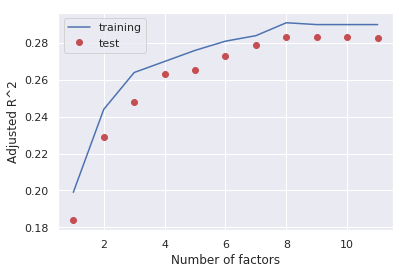

In [20]:
r2_values_rounded = []

# round adjusted R^2 values to reduce sig figs
for i in r2_values:
    r2_values_rounded.append(round(i, 3))

x = np.arange(1,12,1)
y = r2_values_rounded

plt.plot(x, y, 'b');     # plot test data

y2 = []
count = 0
dependants = ""     # string of dependant values

# loop through all chosen factors form the training data model and use them on the test data
for i in factors:
    model = smf.ols(formula='quality ~ {} + {}'.format(dependants, i), data=test_data).fit()
    y2.append(model.rsquared_adj)     # record the adjusted R^2
    if (count == 0):     # if considering first factor in the model
        dependants = i
    else:
        dependants = dependants + " + " + i
    count += 1

plt.plot(x, y2, 'ro')
plt.xlabel('Number of factors')
plt.ylabel('Adjusted R^2')
plt.legend(['training', 'test']);

* The test data performs similarly to the training data.
    * Both datasets plateau at ~7-8 factors. 
* At a cost of 0.2 adjusted R^2, the number of factors in the model could be lowered to ~4 factors for simplicity.
* Nonetheless, the model is still a poor fit to the data.

### Logistic regression

In [21]:
# classifying quality values
wine = wine_cleaned.copy()
wine['quality'] = np.where(wine['quality'] <= 5, 0, 1)     # quality <= 5 = 0, quality > 5 = 1

In [22]:
# converting formula to matrix format
y, X = patsy.dmatrices("C(quality,[[0],[1]]) ~  0 + fixed_acidity + volatile_acidity + citric_acid + \
                residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + \
                density + ph + sulphates + alcohol", data=wine)

# splitting data into training and testing for cross validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

In [23]:
# create a logistic regression model
log_r = sklearn.linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=2000)

# fit the model to training data
log_r_quality = log_r.fit(X_train, y_train.ravel())

# use the model to predict values using test data
quality_hat = log_r_quality.predict(X_test)
log_r_matrix = sklearn.metrics.confusion_matrix(quality_hat, y_test)     # extract the confusion matrix
print('Confusion matrix:\n', pd.DataFrame(log_r_matrix))
print("")

# obtain model accuracy scores
print('Training prediction accuracy {:.3f}'.format(log_r_quality.score(X_train, y_train.ravel())))
print('Test prediction accuracy {:.3f}'.format(log_r_quality.score(X_test, y_test.ravel())))
print("")

log_r_report = sklearn.metrics.classification_report(quality_hat, y_test)     # extract the classification report
print(log_r_report)

Confusion matrix:
      0     1
0  389   214
1  414  1401

Training prediction accuracy 0.754
Test prediction accuracy 0.740

              precision    recall  f1-score   support

         0.0       0.48      0.65      0.55       603
         1.0       0.87      0.77      0.82      1815

   micro avg       0.74      0.74      0.74      2418
   macro avg       0.68      0.71      0.69      2418
weighted avg       0.77      0.74      0.75      2418



* The f1-score of the above average wines is relatively high at ~0.8, much better than the score for the below average wines.
    * This may be due to the modelling having more data to train with from the above average quality wines compared to below average quality (3233 vs. 1603 in the wine dataset).
* The overall accuracy of the model through one iteration is ~0.74.
* To obtain a confident score of this model, the training and test data split and model implementation will be iterated 10 times (to avoid long processing times), and the average score from the test dataset will be selected.


In [24]:
log_r_scores = []

for i in range(10):
    # splitting data into training and testing for cross validation
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)
    
    # fit the model to training data
    log_r_quality = log_r.fit(X_train, y_train.ravel())
    
    # obtain model accuracy score
    log_r_scores.append(log_r_quality.score(X_test, y_test.ravel()))

log_r_scores = np.asarray(log_r_scores)
print("Average score: {:.3f}".format(log_r_scores.mean()))

Average score: 0.745


### K-nearest neighbors (KNN)

* The KNN model will be used twice: once without transformation and once with a normalized transformation.
    * This is done to observe how great of an effect normalizing the data has when conducting a KNN model.
* The K value in the models will be tuned to determine the optimum K value to be used to model the wine data.

In [25]:
# converting data to matrix format
y = wine.quality
X = wine.drop('quality', axis=1)

# splitting data into training and testing for cross validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

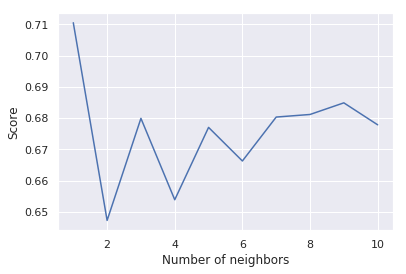


Highest accuracy is obtained when k = 1 --> 0.711 

Confusion matrix:
      0     1
0  444   339
1  361  1274

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       783
           1       0.79      0.78      0.78      1635

   micro avg       0.71      0.71      0.71      2418
   macro avg       0.67      0.67      0.67      2418
weighted avg       0.71      0.71      0.71      2418



In [26]:
accuracy = []
k_values = np.arange(1,11)

for k in k_values:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k)     # create a KNN model
    knn.fit(X_train, y_train.ravel())     # fit the model to training data
    knn_hat = knn.predict(X_test)     # use the model to predict values using test data
    accuracy.append(sklearn.metrics.accuracy_score(knn_hat, y_test))     # obtain model accuracy scores

# plot k values versus their accuracy
plt.plot(k_values, accuracy);
plt.xlabel('Number of neighbors')
plt.ylabel('Score')
plt.show()
print("")

# identify k value with highest accuracy
max_idx = accuracy.index(max(accuracy))
print("Highest accuracy is obtained when k =", k_values[max_idx], "--> {:.3f}".format(accuracy[max_idx]), "\n")

# model the training data based on the k value that gives the best score
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k_values[max_idx])
knn.fit(X_train, y_train.ravel())
knn_hat = knn.predict(X_test)

knn_matrix = sklearn.metrics.confusion_matrix(knn_hat, y_test)     # extract the confusion matrix
print('Confusion matrix:\n', pd.DataFrame(knn_matrix))
print("")
knn_report = sklearn.metrics.classification_report(knn_hat, y_test)     # extract the classification report
print(knn_report)

* The overall performance of this model is only slightly worse compared to the logistic regression model.
* The precision of predicting above average wines for this model is almost 10% less, but predicting the below average wines is slightly more precise.
* To obtain a confident score of this model, the training and test data split and model implementation will be iterated 50 times, and the average score from the test dataset will be selected. 
    * Even though the processing time of KNN is much shorter than logistic regression, iterating the model 500 times vs 50 times resulted in similar average scores (to the hundredth decimal place).

In [27]:
knn_scores = []

for i in range(50):
    # splitting data into training and testing for cross validation
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

    knn.fit(X_train, y_train.ravel())     # fit the model to training data
    knn_hat = knn.predict(X_test)     # use the model to predict values using test data
    knn_scores.append(sklearn.metrics.accuracy_score(knn_hat, y_test))     # obtain model accuracy scores

knn_scores = np.asarray(knn_scores)
print("Average score: {:.3f}".format(knn_scores.mean()))

Average score: 0.712


* Normalizing the data will transform the dataset to contain values that lie between 0 and 1. 
* This is idea when using KNN since the results are modeled based on distances between data points in the modeled space.
* To normalize (min-max normalization) the data, the simple function below will be used.

In [28]:
def normalize(x):
    # formula source: https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)
    z = (x - x.min())/(x.max()-x.min())
    return z

wine_norm = normalize(wine)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


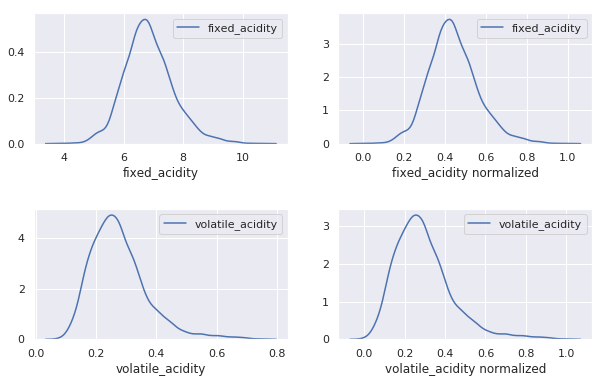

In [29]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6))
plt.subplots_adjust(hspace=0.5, wspace=0.2)
        
c = 0;
# create four kde plots to show affect of normalization
for i in range(2):
    sns.kdeplot(wine[wine.columns[c]], ax=ax[i][0]);
    ax[i][0].set_xlabel(wine.columns[c]);
    sns.kdeplot(wine_norm[wine_norm.columns[c]], ax=ax[i][1]);
    ax[i][1].set_xlabel(wine_norm.columns[c] + ' normalized');
    c += 1

In [30]:
wine_norm.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
count,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000,4836.000000
mean,0.441593,0.292778,0.448302,0.251341,0.178464,0.306262,0.471754,0.450288,0.426150,0.341037,0.406025,0.668528
std,0.120254,0.143013,0.153381,0.216242,0.094783,0.149829,0.152732,0.189377,0.136961,0.143560,0.198315,0.470791
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.362319,0.194030,0.364865,0.048035,0.133005,0.194444,0.362637,0.300196,0.336364,0.240506,0.241935,0.000000
50%,0.434783,0.268657,0.432432,0.200873,0.167488,0.296296,0.457875,0.431001,0.418182,0.316456,0.387097,1.000000
75%,0.507246,0.358209,0.513514,0.402293,0.201970,0.407407,0.578755,0.586985,0.509091,0.417722,0.548387,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Just as a visual confirmation, the KDE plots above show that the distribution shapes are equal before and after normalization for the first two input variables.
    * Based on the axes, it is evident that the distributions on the right have been scaled to fit between 0 and 1.
* The data description above is another confirmation that the normalization process succeeded.
    * All min values are 0 and all max values are 1.

In [31]:
# converting data to matrix format
y = wine_norm.quality
X = wine_norm.drop('quality', axis=1)

# splitting data into training and testing for cross validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

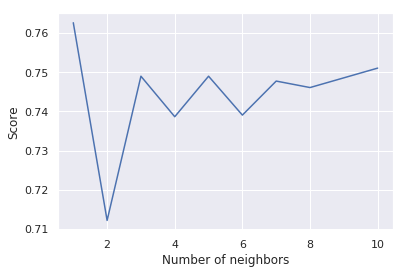


Highest accuracy is obtained when k = 1 --> 0.763 

Confusion matrix:
      0     1
0  516   293
1  281  1328

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64       809
         1.0       0.82      0.83      0.82      1609

   micro avg       0.76      0.76      0.76      2418
   macro avg       0.73      0.73      0.73      2418
weighted avg       0.76      0.76      0.76      2418



In [32]:
accuracy = []
k_values = np.arange(1,11)

for k in k_values:
    knn_n = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k)     # create a KNN model
    knn_n.fit(X_train, y_train.ravel())     # fit the model to training data
    knn_n_hat = knn_n.predict(X_test)     # use the model to predict values using test data
    accuracy.append(sklearn.metrics.accuracy_score(knn_n_hat, y_test))     # obtain model accuracy scores
    
# plot k values versus their accuracy
plt.plot(k_values, accuracy);
plt.xlabel('Number of neighbors')
plt.ylabel('Score')
plt.show()
print("")

# identify k value with highest accuracy
max_idx = accuracy.index(max(accuracy))
print("Highest accuracy is obtained when k =", k_values[max_idx], "--> {:.3f}".format(accuracy[max_idx]), "\n")

# model the training data based on the k value that gives the best score
knn_n = sklearn.neighbors.KNeighborsClassifier(n_neighbors= k_values[max_idx])
knn_n.fit(X_train, y_train.ravel())
knn_n_hat = knn_n.predict(X_test)

knn_n_matrix = sklearn.metrics.confusion_matrix(knn_n_hat, y_test)     # extract the confusion matrix
print('Confusion matrix:\n', pd.DataFrame(knn_n_matrix))
print("")
knn_n_report = sklearn.metrics.classification_report(knn_n_hat, y_test)     # extract the classification report
print(knn_n_report)

* The KNN model scored ~6% higher with the normalized data compared to the non-normalized data. 
* The biggest improvement is f1-score of below average wines, an increase of ~10%.
* To obtain a confident score of this model, the training and test data split and model implementation will be iterated 50 times, and the average score from the test dataset will be selected.


In [33]:
knn_n_scores = []

for i in range(50):
    # splitting data into training and testing for cross validation
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

    knn_n.fit(X_train, y_train.ravel())     # fit the model to training data
    knn_n_hat = knn_n.predict(X_test)     # use the model to predict values using test data
    knn_n_scores.append(sklearn.metrics.accuracy_score(knn_n_hat, y_test))     # obtain model accuracy scores

knn_n_scores = np.asarray(knn_n_scores)
print("Average score: {:.3f}".format(knn_n_scores.mean()))

Average score: 0.769


### Support-vector machine (SVM)
* Although SVM was not covered in class, it is a popular method to use in classification problems.
* SVM model attempts to transform the data onto a plane where the classes can be separated by a single line.
* Decision boundary is called the maximal margin classifier.
    * Maximum distance between points of different classes.
* Variation called support-vector classifier (SVC) has soft margins to regularize the model by allowing some points to cross the margin.
    * The SVC model will SVM model used in this report specifically for the regularization, however all reference to the model will be made as 'SVM'.
* Similar to KNN, since the model uses distance to come up with a decision boundary, the data needs to be normalized.
    * Modeling the data without normalizing was attempted, however the processing time was extremely long, therefore for ease of use and reprocessing, only the normalized data will be modeled.
* Two of the main parameters of the model will be tuned to determine the optimum SVM model for the wine data.
    * kernel: mapping/transformation of the data points in space
    * gamma: coefficient of the kernel

In [34]:
# converting data to matrix format
y = wine_norm.quality
X = wine_norm.drop('quality', axis=1)

# splitting data into training and testing for cross validation
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

In [35]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']     # possible kernal parameters
gamma = ['auto', 'scale']     # possible gamma parameters

svm_n_tuning_scores = []
svm_n_tuning_names = []

for i in kernel:
    for j in gamma:
        svm_n = sklearn.svm.SVC(kernel=i, gamma=j)     # create an SVM model
        svm_n_quality = svm_n.fit(X_train, y_train.ravel())     # fit the model to training data
        svm_n_hat = svm_n.predict(X_test)     # use the model to predict values using test data
        svm_n_tuning_scores.append(svm_n_quality.score(X_test, y_test.ravel()))     # obtain model accuracy scores
        svm_n_tuning_names.append("{}, {}".format(i, j))     # record scores' respective parameters
        
svm_n_dict = dict(zip(svm_n_tuning_names, svm_n_tuning_scores))     # create a dictionary from the two arrays

# print results
print("{:<22} {}".format('kernel, gamma', 'score'))
print("----------------------------")
for key, value in svm_n_dict.items():
    print("{:<22} {:.3f}".format(key, value))
print("")
    
# show max score
svm_n_max_idx = svm_n_tuning_scores.index(max(svm_n_tuning_scores))
print("Maximum score: {:.3f} from {}".format(svm_n_tuning_scores[svm_n_max_idx], svm_n_tuning_names[svm_n_max_idx]))

kernel, gamma          score
----------------------------
linear, auto           0.737
linear, scale          0.737
poly, auto             0.660
poly, scale            0.772
rbf, auto              0.720
rbf, scale             0.773
sigmoid, auto          0.704
sigmoid, scale         0.667

Maximum score: 0.773 from rbf, scale


* Following the parametric tuning, the radial basis function (RBF) kernel and the scale coefficient (1 / (n_features * X.var())) are the best parameters to use for the model. 

In [36]:
svm_n = sklearn.svm.SVC(kernel='rbf', gamma='scale')     # create an SVM model
svm_n_quality = svm_n.fit(X_train, y_train.ravel())     # fit the model to training data
svm_n_hat = svm_n.predict(X_test)     # use the model to predict values using test data

svm_n_matrix = sklearn.metrics.confusion_matrix(svm_n_hat, y_test)     # extract the confusion matrix
print('Confusion matrix:\n', pd.DataFrame(svm_n_matrix))
print("")

# obtain model accuracy scores
print('Training prediction accuracy {:.3f}'.format(svm_n_quality.score(X_train, y_train.ravel())))
print('Test prediction accuracy {:.3f}'.format(svm_n_quality.score(X_test, y_test.ravel())))
print("")
svm_n_report = sklearn.metrics.classification_report(svm_n_hat, y_test)     # extract the classification report
print(svm_n_report)

Confusion matrix:
      0     1
0  458   186
1  364  1410

Training prediction accuracy 0.810
Test prediction accuracy 0.773

              precision    recall  f1-score   support

         0.0       0.56      0.71      0.62       644
         1.0       0.88      0.79      0.84      1774

   micro avg       0.77      0.77      0.77      2418
   macro avg       0.72      0.75      0.73      2418
weighted avg       0.80      0.77      0.78      2418



* The overall performance of this model is similar/just slightly higher compared to the KNN model with normalized data.
    * This also holds for the f1-scores of the SVM model compared to the KNN model.
* To obtain a confident score of this model, the training and test data split and model implementation will be iterated 10 times (to avoid long processing times), and the average score from the test dataset will be selected. 

In [37]:
svm_n_scores = []

for i in range(10):
    # splitting data into training and testing for cross validation
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)

    svm_n_quality = svm_n.fit(X_train, y_train.ravel())     # fit the model to training data
    svm_n_hat = svm_n.predict(X_test)     # use the model to predict values using test data
    svm_n_scores.append(svm_n_quality.score(X_test, y_test.ravel()))     # obtain model accuracy scores

svm_n_scores = np.asarray(svm_n_scores)
print("Average score: {:.3f}".format(svm_n_scores.mean()))

Average score: 0.782


### Comparisons
* Linear regression was a poor fit to the data.
    * Adjusted R^2 of 0.287 means that the model only reduced the variance by 28.7%.
* Alcohol and volatile acidity are the two best factors in a linear model. 

In [38]:
comp = pd.DataFrame(columns=['Model', 'Score/Accuracy'])

# collect names and scores of each classification model
model_names = ['Logistic regression', 'KNN', 'KNN (normalized)', 'SVM (normalized)']
model_scores = [log_r_scores, knn_scores, knn_n_scores, svm_n_scores]

# sort them into the dataframe
for i in range(len(model_names)):
     comp.loc[i] = [model_names[i]] + [model_scores[i].mean()]

comp

,Model,Score/Accuracy
0,Logistic regression,0.745037
1,KNN,0.712349
2,KNN (normalized),0.769380
3,SVM (normalized),0.782465


* The SVM and KNN (both normalized) models both roughly have an overall model accuracy score. 
* The ~6% jump between the non-normalized and normalized data signifies how important it is to scale the data when using models that use Euclidean distance as its basis.

In [39]:
# collect model names, classsification reports, and confusion matrices for the classification models
model_names = ['Logistic regression', 'KNN', 'KNN (normalized)', 'SVM (normalized)']
reports = [log_r_report, knn_report, knn_n_report, svm_n_report]
matrices = [log_r_matrix, knn_matrix, knn_n_matrix, svm_n_matrix]
for i in range(len(model_names)):
    print('------------------------------------------------------')
    print(model_names[i])
    print('------------------------------------------------------')
    print("")
    print(matrices[i])
    print("")
    print(reports[i])

------------------------------------------------------
Logistic regression
------------------------------------------------------

[[ 389  214]
 [ 414 1401]]

              precision    recall  f1-score   support

         0.0       0.48      0.65      0.55       603
         1.0       0.87      0.77      0.82      1815

   micro avg       0.74      0.74      0.74      2418
   macro avg       0.68      0.71      0.69      2418
weighted avg       0.77      0.74      0.75      2418

------------------------------------------------------
KNN
------------------------------------------------------

[[ 444  339]
 [ 361 1274]]

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       783
           1       0.79      0.78      0.78      1635

   micro avg       0.71      0.71      0.71      2418
   macro avg       0.67      0.67      0.67      2418
weighted avg       0.71      0.71      0.71      2418

--------------------------------------------

* Based on the classification reports above, it is evident that the model accuracy is always reduced by low scores from predicting below average wine.
* However, model accuracy is not the only parameter that needs to be looked at.
* Precision: correct / total
    * All of the models did not do well in correctly identifying below average wine, leading to many wines being left to be incorrectly classified as above average wine.
    * However, the models were great in choosing the above average wine.
        * As mentioned before, this may be due to the lower frequency of below average wine data points compared to above average wines, leading to better training to recognize above average wins. 
* Recall: correct / classified
    * For KNN (non-normalized), almost half of the below average wine was not identified.
        * This would be the same as choosing a wine at random and classifying it as below average.
    * Although not great, the KNN (normalized) and SVM performed much better for below average wine.
    * All the models did well in correctly classifying above average wine.
* f1-score: weighted average of precision and recall
    * This parameter is the most important for this project when analysing the performance of the model on each classification.
    * One of the goals of this project is to determine if the quality of white wines can be modeled based on their physicochemical properties.
    * Therefore missing out on predicting the correct quality of a wine (too safe) and mis-predicting a large number of wines (too aggressive) should both be taken into consideration, which is what the f1-score does. 
    * Based on this, the SVM and KNN (normalized) models both performed the best in predicting the quality of wine, followed by logistic regression and finally KNN (non-normalized).
    * The logistic regression model could have matched the SVM and KNN models, however its low precision for below average wines reduced its respective f1-score.


---

## Discussion and conclusion
* The problem sought to explore for this project was if the quality of wine (specifically white wine) is entirely subjective or can it be modeled.
* Linear regression turn out to be a poor fit to the data.
    * This may have been due to collinearity between the input variables, however the forward stepwise subset selection process showed that even using the three most significant variables to model the quality, variables that do not have any strong collinearity between each other, the model was only able to generate an adjusted R^2 of 0.264. 
    * Therefore, there is a possibility that the relationship between the input variables and the quality is simply not linear.
* The linear regression model did confirm half of my hypothesis that alcohol would be one of the best factors to model wine quality.
    * The other half of the hypothesis predicted density would be a strong factor too, however due to the presence of alcohol in the model and the correlation between the two variables, density was chosen after volatile acidity, free sulfur dioxide, and residuals sugar.
* Due to the low frequency of data points for low and high quality wine, the quality variable was transformed from a scale of 0 to 10 to a binary classification. 
* With twice as many above average wine data points as below average, all of the classification models scored higher on all evaluation properties for above average wine. 
    * With a training and test split of 50/50, the models had ~800 data points to model below average wine.
    * This may not have been enough since the f1-scores ranged from ~0.55 to ~0.65.
    * The models obtained much higher f1-scores for above average wine, around ~0.78 to 0.84.
* In the end, the SVM and KNN models using normalized data scored the highest on accuracy (~0.77) and f1-score (~0.78). 
* Suggestions to improve:
    * Collect uniform and high frequency of data for all quality scores (if possible).
    * Explore and use more classification models not taught in the course.
